In [36]:
import torch
import torchvision
from torchvision import transforms ,models
import os
from torch.utils.data.dataset import Dataset
from glob import glob as glob
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [37]:
import pickle 
with open ( '../dataset/combined_annotations_processed.pkl' , 'rb') as f:
    anno_train_json = pickle.load(f)

In [38]:
class SVHNTEST(Dataset):
    def __init__(self, phase, anno_file ,augment):
        self.transforms = augment
        self.anno_file = anno_file
        self.phase = phase
        if phase == 'train':
            self.img_paths = glob('../dataset/coco_format_combined/train/*')
        if phase == 'val':
            self.img_paths = glob('../dataset/coco_format_combined/val/*')
        if phase == 'test':
            self.img_paths = glob('../dataset/testsvhn/*')
        self.dataset_size = len(self.img_paths)
        
            

    def __getitem__(self, index):

        A_path = self.img_paths[index]
        A_image = Image.open(A_path)
        A_image_transformed = self.transforms(A_image)
        
        if self.phase == 'train' or self.phase == 'val':
            A_label_org = self.anno_file[os.path.basename(A_path)]['label']
            A_lable_final = torch.zeros(10)
            for i in A_label_org:
                A_lable_final[i] = 1
            A_lable_final = torch.tensor(A_lable_final)

            return A_image_transformed,A_lable_final
        
        if self.phase == 'test':
            return A_image_transformed

    def __len__(self):
        return self.dataset_size

    def name(self):
        return 'SVHNTEST'

In [39]:
from torchvision import transforms
from PIL import Image
augment = {}
augment['1'] = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),
#     transforms.RandomResizedCrop(64),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])  # change to [C, H, W]
augment['2'] = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])  # change to [C, H, W]

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# Test the Model
model = torch.load('../../../dataset/cnn_classifier/good_result/output_model_fulldata_pretrain/29.pth')
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
test_dataset = SVHNTEST('test',anno_train_json,augment['2'])
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             pin_memory=True,
                             drop_last = True)

In [43]:
inputs = next(iter(test_dataloader))
with torch.no_grad():    
    inputs = inputs.to(device)
    outputs = F.sigmoid(model(inputs))

/home/deep/.virtualenvs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.0480, 0.2948, 0.1851, 0.3175, 0.4173, 0.2603, 0.2251, 0.1480, 0.1244,
        0.1705], device='cuda:0')


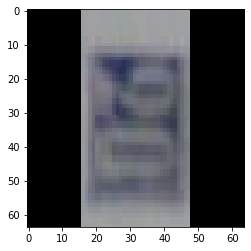

In [49]:
from matplotlib import pyplot as plt
index = random.randint(0,31)
image_numpy = inputs[index].cpu().float().numpy()
image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
plt.imshow(Image.fromarray(np.array(image_numpy,dtype=np.uint8)))
print(outputs[index])